# Transforming Descriptors to Images

Traditionally, computed descriptors in cheminformatics have been represented in tabular data format. However, increasing interest has been in transforming non-image samples into image-like representations, which can be applied in image-oriented neural network architectures like Convolutional Neural Networks (CNNs). DeepInsight (A. Sharma et al., 2019) proposes a unique solution by utilizing CNNs to extract features from non-image samples, subsequently converting them into images that CNNs can further process. Although this methodology has shown some promise in certain domains according to its authors, such as prediction tasks on RNA-seq, vowel, and text datasets, and has the potential to enhance the flexibility of CNN architectures in cheminformatics, it is crucial to be mindful of any biases favouring image-based cheminformatics methods. We use the VGG-16 model introduced by Simonyan and Zisserman (2014), a baseline convolutional neural network architecture for various computer vision tasks, to train and make predictions based on these image representations of the molecular descriptors. The VGG-16 architecture comprises 16 weight layers, 13 convolutional layers and three fully connected layers. It also incorporates five max-pooling layers for down-sampling and reducing the spatial dimensions of feature maps. In addition, the model is characterized by its use of small 3x3 convolutional filters and depth, which significantly improves its performance compared to shallower architectures.

In [3]:
from data.dataset import Dataset
import torchvision
import torch.nn as nn
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
DEVICE = torch.device("cuda")

In [3]:
TRN = Dataset.load_csv("ds/2019trn/TRN_All")
TST_SET_1 = Dataset.load_csv("ds/all/TST_1_All")
TST_SET_2 = Dataset.load_csv("ds/all/TST_2_All")

In [4]:
from data.featurization.deepinsight import DeepInsight

featurizer = DeepInsight(pixels=(224, 224))
TRN.X = TRN.featurize(featurizer)
TST_SET_1.X = TST_SET_1.featurize(featurizer)
TST_SET_2.X = TST_SET_2.featurize(featurizer)

C:\Users\ecbur\Desktop\BASE\Workspace\ST_ANDREWS\CS4099\REPO\Solubility-Prediction\data\featurization\deepinsight.py:43: UserWarning: [DeepInsight]: Xs must be converted to tabular data (unchecked)
  warnings.warn(DeepInsight.USER_WARNING_MSG, UserWarning)
C:\Users\ecbur\Desktop\BASE\Workspace\ST_ANDREWS\CS4099\REPO\Solubility-Prediction\data\featurization\deepinsight.py:43: UserWarning: [DeepInsight]: Xs must be converted to tabular data (unchecked)
  warnings.warn(DeepInsight.USER_WARNING_MSG, UserWarning)
C:\Users\ecbur\Desktop\BASE\Workspace\ST_ANDREWS\CS4099\REPO\Solubility-Prediction\data\featurization\deepinsight.py:43: UserWarning: [DeepInsight]: Xs must be converted to tabular data (unchecked)
  warnings.warn(DeepInsight.USER_WARNING_MSG, UserWarning)


In [5]:
vgg16 = torchvision.models.vgg16(pretrained=True)

C:\Users\ecbur\Desktop\BASE\SDK\Conda\envs\StA4099\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\ecbur\Desktop\BASE\SDK\Conda\envs\StA4099\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
trn_x = [tensor.float() for tensor in TRN.X["image"].values.tolist()]
trn_y = TRN.y["LogS exp (mol/L)"].tolist()

tst1_x = [tensor.float() for tensor in TST_SET_1.X["image"].values.tolist()]
tst1_y = TST_SET_1.y["LogS exp (mol/L)"].tolist()

tst2_x = [tensor.float() for tensor in TST_SET_2.X["image"].values.tolist()]
tst2_y = TST_SET_2.y["LogS exp (mol/L)"].tolist()

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert your list of tensors and labels into PyTorch tensors
train_data = torch.stack(trn_x)
train_labels = torch.tensor(trn_y)
test_data = torch.stack(tst1_x)
test_labels = torch.tensor(tst1_y)

# Create a TensorDataset with the data and labels
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create a DataLoader for the training and test sets
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg16.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
vgg16.classifier[6] = nn.Linear(4096, 1)
vgg16 = vgg16.to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)

best_rmse = 100
best_r2 = -100

# Train the model
for epoch in range(100):
    vgg16.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    vgg16.eval()
    predictions = []
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(DEVICE)
        outputs = vgg16(inputs).cpu()
        predictions.append(outputs.detach().numpy())
    predictions = np.concatenate(predictions)
    rmse = mean_squared_error(TST_SET_1.y, predictions, squared=False)
    r2 = r2_score(TST_SET_1.y, predictions)

    best_rmse = min(rmse, best_rmse)
    best_r2 = max(r2, best_r2)

    print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, rmse: {rmse}, r2: {r2}")

In [11]:
# Make predictions
predictions = []
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(DEVICE)
        outputs = vgg16(inputs).cpu()
        predictions.append(outputs.numpy())

predictions = np.concatenate(predictions)

In [ ]:
print(f"TST1 : RMSE {mean_squared_error(TST_SET_1.y, predictions, squared=False)}")
print(f"TST1 : R^2 {r2_score(TST_SET_1.y, predictions)}")

(-11.0, -1.0)

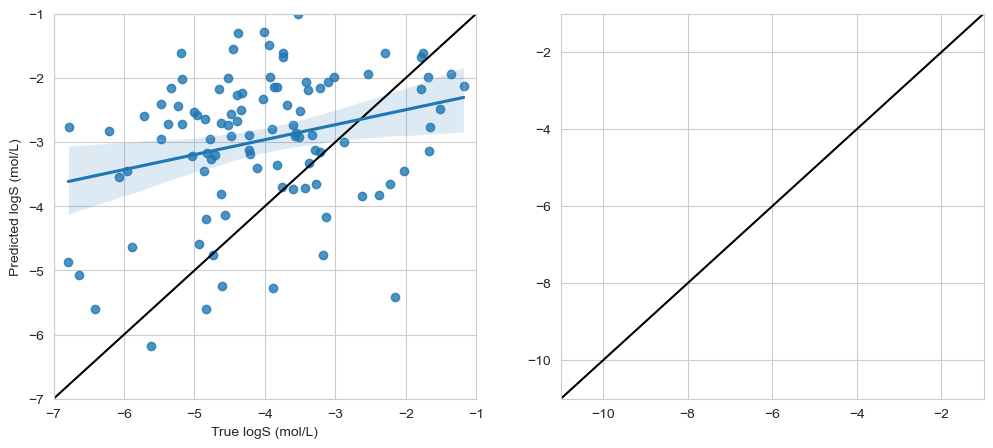

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GCN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST_SET_1.y.values[:, 0],
        "Predicted logS (mol/L)": predictions[:, 0].tolist()
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

# ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
#               f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")

# plt.axis("equal")